In [2]:
import os
import pickle
from datetime import datetime
from enum import Enum, auto
from functools import cached_property
from itertools import chain
from pathlib import Path
from random import random, randint
from time import sleep
from typing import Dict, List

In [3]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from numpy.random import normal
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import pickle
import matplotlib.pyplot as plt
import scipy.stats as st

In [5]:
# Five states are defined, and the five states are mutually exclusive, each person’s state is unique
class State(Enum):
    # There are two places to change the order of adjustment status: here, and the order of histories below (search for histories)
    eliminated = auto()
    susceptible = auto()
    recovered = auto()
    infected = auto()
    dead = auto()

In [6]:
class Person(Agent):
    
    def __init__(self, unique_id: int, model: 'EbolaModel'):
        super().__init__(unique_id, model)
        self.model = model
        self.induced_infections = 0  # induced_infections is 0
        self.infected_days = 0    # infected days
        self.dead_days = 0  # dead days
        
        # Calculate the progression period of agents
        threshold = np.round(normal(self.model.progression_period_mean, self.model.progression_period_std))
        threshold = threshold if threshold >= self.model.progression_period_min else self.model.progression_period_min
        self.progression_threshold = threshold
        # Calculate the recovery days of agents，this happens on the basis of the progression period
        threshold = np.round(normal(self.model.recover_days_mean, self.model.recover_days_std))
        threshold = threshold if threshold >= self.model.recover_days_min else self.model.recover_days_min
        threshold += self.progression_threshold
        self.recover_threshold = threshold
        # Calculate the eliminated days of agents
        threshold = np.round(normal(self.model.eliminated_days_mean, self.model.eliminated_days_std))
        threshold = threshold if threshold >= self.model.eliminated_days_min else self.model.eliminated_days_min
        self.eliminated_threshold = threshold
        # Set the initial state to more accurately determine whether it is "susceptible" or "infected"(Probability, number line）
        self.state = State.susceptible if random() > model.initial_infected_rate else State.infected
        
    def step(self):
            self.check_eliminated()#check if remove the dead agent
            self.move_and_add_infected_time()  # move automaticaly
            self.check_recover()  # check if recover
            self.check_death()  # check if dead
            self.interact()  # check if interact with other agents
            
    def check_eliminated(self):
        # will not be elimated if not dead
        if self.state != State.dead:
            return
        
        # Current status: dead
        # dead days+1
        self.dead_days += 1
        # Check whether it exceeds the limit, and remove it if it exceeds
        if self.dead_days >= self.eliminated_threshold:
            self.state = State.eliminated
                    
    def move_and_add_infected_time(self):
        # if dead, do not move
        if self.state in (State.dead, State.eliminated):
            return
        
        #current status: susceptible, infected, recovered
        #step to new position(neighborhood)
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        new_position = self.random.choice(possible_steps)
        #move agents to new position
        self.model.grid.move_agent(self, new_position)
        
        # if infected, days+1
        if self.state == State.infected:
            self.infected_days += 1
            
    def check_recover(self):
        # if not infected, no need to recover
        if self.state not in (State.infected,):
            return
        
        # Current status: Infected
        # If the infection time does not reach the limit, it will not be recovered
        if self.infected_days <= self.recover_threshold:
            return
        
        # Current status: infected and exceeded the recovery limit time
        # Set the status to be recovered
        self.state = State.recovered
        
    def check_death(self):
        # if not infected, could not dead
        if self.state != State.infected:
            return
        
        # If still in progression period, could not dead
        if self.infected_days < self.progression_threshold:
            return
        
        # Current status: Infected
        # Determine whether death is based on probability
        if random() < self.model.death_rate:
            self.state = State.dead
            
    def interact(self):
        # if not infected, no dead, do not infect other agents
        if self.state not in (State.infected, State.dead):
            return
        
        # Current status: Infected or Dead
        # If infected, infect other agents
        #if self.state in (State.infected, ): # do not infected others if dead
        if self.state in (State.infected, State.dead):  # keep infecting others if dead
            neighbours: List[Person] = self.model.grid.get_neighbors(self.pos, moore=False, include_center=True)# get_neighbors, include moore and center
            neighbours = [n for n in neighbours if n is not self]#exclude itself
            [self.infect(neighbour) for neighbour in neighbours]#infect the neighbours
            
    def infect(self, other: 'Person'):
        # current status: self infected or dead, other unknown
        # if other is not susceptible, will not be infected
        if other.state != State.susceptible:
            return
        
        # current status: self infected or dead, other is susceptible
        #if self is "infected" not "dead", check progression period; If it is still in the progression period, no infection
        if self.state == State.infected and self.infected_days < self.progression_threshold:
            return
        
        # current status: self infected or dead, self not in progression period, other is susceptible
        # If the random number is greater than this probability, no infection
        if random() > self.model.transmission_probability:
            return
        
        # set other status as infected
        other.state = State.infected
        self.induced_infections += 1

In [7]:
#Model class
class EbolaModel(Model):
    #Set all the parameters and the height, width of grid, we use multigrid in this model
    #Simplify the model
    #random_seed = 1578(not necessary for now)
    grid_height = 150
    grid_width = 150
    initial_infected_rate = 0.11
    transmission_probability = 0.44
    population = 5000
    death_rate = 0.1
    steps = 100
    output_path = 'output'
    progression_period_mean = 8
    progression_period_std = 1
    progression_period_min = 1
    recover_days_mean = 7
    recover_days_std = 1
    recover_days_min = 1
    eliminated_days_mean = 3
    eliminated_days_std = 2
    eliminated_days_min = 1
    #title = 'this is a title'

    # The first one is the background color, and the others correspond to the values in State in turn
    colors = ['white', '#0072BD', '#F6A9A9','#77AC30','#FFB740', '#B61919']
    
    #save the parameters value with each result
    def save_parameters(self):
        items = chain.from_iterable([vars(klass).items() for klass in self.__class__.mro()])
        parameters = [(k, v) for k, v in items if isinstance(v, (int, float, str))]
        parameters = [(k, v) for k, v in parameters if not k.startswith('_')]
        content = '\n'.join(f'{k} = {v}' for k, v in parameters)
        with open(self.path / 'parameters.txt', 'w', encoding='utf-8') as f:
            f.write(content)
    
    def __init__(self):
        super().__init__(Model)
        # random seed, just an experiment
        # np.random.seed(self.random_seed)
        # seed(self.random_seed)
        
        # Used for stored procedure variables
        self.susceptible_history = []
        self.infected_history = []
        self.recovered_history = []
        self.dead_history = []
        self.eliminated_history = []
        self.r0_history = []
 
        #set the grid of the model, use multigrid
        self.grid = MultiGrid(width=self.grid_height, height=self.grid_width, torus=True)
        self.schedule = RandomActivation(self)
        self.agents: Dict[int, Person] = {}
        
        #add agents into the multigrid
        for node in range(self.population):
            person = Person(node, self)
            # Group to random positions, one contains two possible elements, which are ranks
            self.grid.place_agent(person, (randint(0, self.grid_height - 1), randint(0, self.grid_width - 1)))
            self.schedule.add(person)
            self.agents[node] = person
        self.record()#record all the time
        
    @cached_property
    def path(self):
        try:
            f = __file__
        except NameError:
            f = '.'
        time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        path = Path(f).absolute().parent / self.output_path / time
        path.exists() or os.makedirs(self.path)
        return path

    #instead if using datacollector, simply use the record(self) here to record all the data 
    def record(self):
        self.recovered_history.append(len([p for p in self.agents.values() if p.state == State.recovered]))
        self.dead_history.append(len([p for p in self.agents.values() if p.state == State.dead]))
        self.infected_history.append(len([p for p in self.agents.values() if p.state == State.infected]))
        self.susceptible_history.append(len([p for p in self.agents.values() if p.state == State.susceptible]))
        self.eliminated_history.append(len([p for p in self.agents.values() if p.state == State.eliminated]))
        self.r0_history.append(self.get_r0())#the r0 is Real-time calculated, add()here or use @property before r0(self)

    def get_r0(self):
        agents = self.agents.values()
        #If dead, not participate in the calculation of R0(dead, not infect)
        #agents = [value for value in agents if value.state != State.dead]
        agents = [value for value in agents if value.induced_infections]#if dead, participate in the calculation of R0(dead, infect too)
        infections = [agent.induced_infections for agent in agents]
        return sum(infections) / len(infections) if infections else 0 #calculate r0

    #step and record
    def step(self):
        self.schedule.step()
        self.record()
    
    #model run, draw the grid, plotting SIRD, export excel
    def run(self,draw=False):
        draw and self.save_parameters()
        draw and self.draw_state()
        draw and self.draw_count()
        for _ in range(self.steps):
            self.step()
        draw and self.draw_state()
        draw and self.draw_count()
        draw and self.draw_sir()
        draw and self.export_excel()
    
    #draw the grid(multigrid)-state of agents
    def draw_state(self, show=False):
        figure = plt.Figure(figsize=(30, 20))
        state_array = np.zeros((self.grid.width, self.grid.height), dtype=int)
        for cell_content, x, y in self.grid.coord_iter():
            cell_content: List[Person]
            states = [c.state.value for c in cell_content]
            state = max(states) if states else 0
            state_array[x][y] = state
        axes: plt.Axes = figure.add_subplot(111)
        axes.imshow(state_array, interpolation='nearest', cmap=ListedColormap(self.colors), vmin=0, vmax=5)
        labels = ['background'] + [i.name for i in State]
        patches = [Patch(color=color, label=label) for label, color in zip(labels, self.colors)]
        axes.legend(handles=patches)
        axes.set_title(self.title)
        show and figure.show()
        figure.savefig(self.path / f'state-{self.schedule.steps}.png', dpi=100)
    
    #draw the agent count in each cell of thr grid
    def draw_count(self, show=False):
        figure = plt.Figure(figsize=(30, 20))
        state_array = np.zeros((self.grid.width, self.grid.height), dtype=int)
        for cell_content, x, y in self.grid.coord_iter():
            state_array[x][y] = len(cell_content)
        axes: plt.Axes = figure.add_subplot(111)
        image = axes.imshow(state_array, interpolation='nearest')
        axes.set_title(self.title)
        figure.colorbar(image, orientation='vertical')
        show and figure.show()
        figure.savefig(self.path / f'count-{self.schedule.steps}.png', dpi=100)
    
    #plotting SIRD and r0,r0 is too small, so use r0*self population
    def draw_sir(self):
        figure: plt.Figure = plt.figure()
        ax: plt.Axes = figure.add_subplot(111)
            
        # When modifying the order of the five states, change the order here too
        histories = [
            self.eliminated_history,
            self.susceptible_history,
            self.recovered_history,
            self.infected_history,
            self.dead_history,
        ]
        config = list(zip((s.name for s in State), histories, self.colors[1:]))
        for label, values, color in config + [
            ('R0', [r * self.population for r in self.r0_history], 'purple'),
        ]:
            ax.plot(values, label=label, color=color)
        plt.xlabel('Day')
        plt.ylabel('Population')
        ax.legend()
        ax.set_title(self.title)
        figure.savefig(self.path / 'sir.png', dpi=300)
    
    #export excel
    def export_excel(self):
        df = pandas.DataFrame(data=np.array([
            self.r0_history,
            self.susceptible_history,
            self.infected_history,
            self.recovered_history,
            self.dead_history,
            self.eliminated_history
        ]).T, columns=['R0', 'susceptible', 'infected', 'recovered', 'dead','eliminated'])
        df.to_excel(self.path / 'data.xlsx')
        
    #def output_eliminated(self):
        #return self.eliminated_history[-1]

In [19]:
def main():
    populations = [1000,3000,5000,7000,9000]
    # populations = list(range(100, 700, 200))
    repetition_times = 50
    result = []
    for p in populations:
        # for eliminated_days in np.arange(2, 8, 1):
        for eliminated_days in [2, 3, 4, 5, 6, 7]:
            for i in range(repetition_times):
                print(p, eliminated_days, i)

                class SubModel(EbolaModel):
                    death_rate = 0.1
                    recover_days_mean = 7
                    initial_infected_rate = 0.11
                    progression_period_mean = 8
                    transmission_probability = 0.44  

                    grid_width = 150
                    grid_height = 150
                    population = p
                    eliminated_days_mean = eliminated_days
                    steps = 100

                model = SubModel()
                model.run(draw=False)
                # 计算存活率，作为模型的唯一输出结果，用于后面的分析
                alive_rate = (model.susceptible_history[-1] + model.recovered_history[-1]) / p
                result.append((p, eliminated_days, i, alive_rate,
                               model.eliminated_history[-1],
                               model.susceptible_history[-1],
                               model.recovered_history[-1],
                               model.infected_history[-1],
                               model.dead_history[-1],
                               ))
    df = pandas.DataFrame(data=result, columns=[
        'population', 'eliminated_days', 'repetition', 'alive_rate',
        'eliminated_number', 'susceptible_number', 'recovered_number', 'infected_number', 'dead_number',
    ])
    time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    df.to_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/population_eliminatedays.csv', index=False)
    #df.to_excel(f'output/data-{time}.xlsx', index=False)

In [20]:
if __name__ == '__main__':
    main()

1000 2 0
1000 2 1
1000 2 2
1000 2 3
1000 2 4
1000 2 5
1000 2 6
1000 2 7
1000 2 8
1000 2 9
1000 2 10
1000 2 11
1000 2 12
1000 2 13
1000 2 14
1000 2 15
1000 2 16
1000 2 17
1000 2 18
1000 2 19
1000 2 20
1000 2 21
1000 2 22
1000 2 23
1000 2 24
1000 2 25
1000 2 26
1000 2 27
1000 2 28
1000 2 29
1000 2 30
1000 2 31
1000 2 32
1000 2 33
1000 2 34
1000 2 35
1000 2 36
1000 2 37
1000 2 38
1000 2 39
1000 2 40
1000 2 41
1000 2 42
1000 2 43
1000 2 44
1000 2 45
1000 2 46
1000 2 47
1000 2 48
1000 2 49
1000 3 0
1000 3 1
1000 3 2
1000 3 3
1000 3 4
1000 3 5
1000 3 6
1000 3 7
1000 3 8
1000 3 9
1000 3 10
1000 3 11
1000 3 12
1000 3 13
1000 3 14
1000 3 15
1000 3 16
1000 3 17
1000 3 18
1000 3 19
1000 3 20
1000 3 21
1000 3 22
1000 3 23
1000 3 24
1000 3 25
1000 3 26
1000 3 27
1000 3 28
1000 3 29
1000 3 30
1000 3 31
1000 3 32
1000 3 33
1000 3 34
1000 3 35
1000 3 36
1000 3 37
1000 3 38
1000 3 39
1000 3 40
1000 3 41
1000 3 42
1000 3 43
1000 3 44
1000 3 45
1000 3 46
1000 3 47
1000 3 48
1000 3 49
1000 4 0
1000 4 1
10

5000 6 37
5000 6 38
5000 6 39
5000 6 40
5000 6 41
5000 6 42
5000 6 43
5000 6 44
5000 6 45
5000 6 46
5000 6 47
5000 6 48
5000 6 49
5000 7 0
5000 7 1
5000 7 2
5000 7 3
5000 7 4
5000 7 5
5000 7 6
5000 7 7
5000 7 8
5000 7 9
5000 7 10
5000 7 11
5000 7 12
5000 7 13
5000 7 14
5000 7 15
5000 7 16
5000 7 17
5000 7 18
5000 7 19
5000 7 20
5000 7 21
5000 7 22
5000 7 23
5000 7 24
5000 7 25
5000 7 26
5000 7 27
5000 7 28
5000 7 29
5000 7 30
5000 7 31
5000 7 32
5000 7 33
5000 7 34
5000 7 35
5000 7 36
5000 7 37
5000 7 38
5000 7 39
5000 7 40
5000 7 41
5000 7 42
5000 7 43
5000 7 44
5000 7 45
5000 7 46
5000 7 47
5000 7 48
5000 7 49
7000 2 0
7000 2 1
7000 2 2
7000 2 3
7000 2 4
7000 2 5
7000 2 6
7000 2 7
7000 2 8
7000 2 9
7000 2 10
7000 2 11
7000 2 12
7000 2 13
7000 2 14
7000 2 15
7000 2 16
7000 2 17
7000 2 18
7000 2 19
7000 2 20
7000 2 21
7000 2 22
7000 2 23
7000 2 24
7000 2 25
7000 2 26
7000 2 27
7000 2 28
7000 2 29
7000 2 30
7000 2 31
7000 2 32
7000 2 33
7000 2 34
7000 2 35
7000 2 36
7000 2 37
7000 2 38


#if __name__ == '__main__':
lines = main()

pops = np.arange(5000, 10000, 2000)
for line in lines:
    plt.plot(pops, line)


In [21]:
df = pandas.read_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/population_eliminatedays.csv')
df

,population,eliminated_days,repetition,alive_rate,eliminated_number,susceptible_number,recovered_number,infected_number,dead_number
0,1000,2,0,0.904000,96,827,77,0,0
1,1000,2,1,0.883000,117,817,66,0,0
2,1000,2,2,0.901000,99,819,82,0,0
3,1000,2,3,0.908000,92,836,72,0,0
4,1000,2,4,0.913000,87,835,78,0,0
...,...,...,...,...,...,...,...,...,...
1495,9000,7,45,0.433556,5098,54,3848,0,0
1496,9000,7,46,0.430667,5124,98,3778,0,0
1497,9000,7,47,0.434889,5086,71,3843,0,0
1498,9000,7,48,0.430889,5122,66,3812,0,0


In [22]:
pt = df.pivot_table(['alive_rate'], index=['population', 'eliminated_days'],
                    aggfunc=lambda v: sum(v) / len(v))
pt = pt.reset_index()
pt

,population,eliminated_days,alive_rate
0,1000,2,0.899820
1,1000,3,0.899420
2,1000,4,0.895620
3,1000,5,0.896420
4,1000,6,0.890040
5,1000,7,0.887740
6,3000,2,0.730393
7,3000,3,0.713313
8,3000,4,0.700327
9,3000,5,0.684893


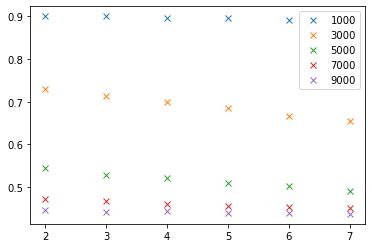

In [23]:
fig, ax = plt.subplots()
for key, group in pt.groupby(['population']):
    # print(group)
    ax.plot(group.eliminated_days, group.alive_rate, 'x', label=str(key))
    fig.savefig('C:/Users/hx055/Desktop/MRes Dissertation/visualisation/population_0.25.png', dpi=300)
ax.legend()

In [24]:
pt = df.pivot_table(['alive_rate'], index=['population', 'eliminated_days'],
                    aggfunc=('mean', 'std'))
pt = pt.reset_index()
pt

population eliminated_days alive_rate          
                                    mean       std
0        1000               2   0.899820  0.011183
1        1000               3   0.899420  0.012886
2        1000               4   0.895620  0.012755
3        1000               5   0.896420  0.013006
4        1000               6   0.890040  0.012132
5        1000               7   0.887740  0.013721
6        3000               2   0.730393  0.014187
7        3000               3   0.713313  0.015061
8        3000               4   0.700327  0.013831
9        3000               5   0.684893  0.013914
10       3000               6   0.667547  0.013426
11       3000               7   0.655413  0.013680
12       5000               2   0.544388  0.008663
13       5000               3   0.528868  0.008825
14       5000               4   0.521456  0.008522
15       5000               5   0.510556  0.006468
16       5000               6   0.502364  0.008852
17       5000               7   0.490656  0.008779
18       7000               2   0.472400  0.005641
19       7000               3   0.467049  0.006366
20       7000               4   0.461040  0.006058
21       7000               5   0.456471  0.006642
22       7000               6   0.452983  0.006206
23       7000               7   0.450723  0.006478
24       9000               2   0.447400  0.005209
25       9000               3   0.442400  0.005242
26       9000               4   0.444140  0.006178
27       9000               5   0.440587  0.006070
28       9000               6   0.439589  0.005055
29       9000               7   0.437522  0.005549

In [41]:
def main():
    result = []
    for p in [5000]:
        for i in range(100): # iterate！
            print(i)
        #for eliminated_days in (3, 4, 5, 6):
            eliminated_days = 3
            class SubModel(EbolaModel):
                population = p
                eliminated_days_mean = eliminated_days

            model = SubModel()
            model.run(draw=False)
            result.append((i, #alive_rate,
                           model.eliminated_history[-1],
                           model.susceptible_history[-1],
                           model.recovered_history[-1],
                           model.infected_history[-1],
                           model.dead_history[-1],
                          ))
    df = pandas.DataFrame(data=result, columns=[
        'repetition', #'alive_rate',
        'eliminated_number', 'susceptible_number', 'recovered_number', 'infected_number', 'dead_number',
    ])
    time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    df.to_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/5000_dead.csv', index=False)
    #df.to_excel(f'output/data-{time}.xlsx', index=False)

In [42]:
if __name__ == '__main__':
    main()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [86]:
df = pandas.read_csv('.csv')
df

,repetition,eliminated_number,susceptible_number,recovered_number,infected_number,dead_number
0,0,1496,3331,171,1,1
1,1,1678,3116,205,0,1
2,2,1571,3261,167,1,0
3,3,1509,3304,187,0,0
4,4,1567,3230,196,6,1
...,...,...,...,...,...,...
95,95,1628,3180,188,4,0
96,96,1620,3190,190,0,0
97,97,1668,3137,191,1,3
98,98,1653,3165,177,2,3


In [102]:
def main():
    result = []
    for p in [5000]:
        for i in range(100): # iterate！
            print(i)
        #for eliminated_days in (3, 4, 5, 6):
            eliminated_days = 3
            class SubModel(EbolaModel):
                population = p
                eliminated_days_mean = eliminated_days

            model = SubModel()
            model.run(draw=False)
            result.append((i, #alive_rate,
                           model.eliminated_history[-1],
                           model.susceptible_history[-1],
                           model.recovered_history[-1],
                           model.infected_history[-1],
                           model.dead_history[-1],
                          ))
    df = pandas.DataFrame(data=result, columns=[
        'repetition', #'alive_rate',
        'eliminated_number', 'susceptible_number', 'recovered_number', 'infected_number', 'dead_number',
    ])
    time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    df.to_csv('.csv', index=False)
    #df.to_excel(f'output/data-{time}.xlsx', index=False)

In [103]:
if __name__ == '__main__':
    main()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [25]:
def main():
#     populations = [5000]
    death_rate = [0.25,0.4,0.55,0.7,0.85]
    repetition_times = 1
    result = []
    for d in death_rate:
        # for eliminated_days in np.arange(2, 8, 1):
        for eliminated_days in [2, 3, 4, 5, 6, 7]:
            for i in range(repetition_times):
                print(d, eliminated_days, i)
                    
                class SubModel(EbolaModel):
                    death_rate = d
                    recover_days_mean = 7
                    initial_infected_rate = 0.11
                    progression_period_mean = 8
                    transmission_probability = 0.44  
                    
                    grid_width = 150
                    grid_height = 150
                    population = 5000
                    eliminated_days_mean = eliminated_days
                    steps = 100
                    
                model = SubModel()
                model.run(draw=False)
                # 计算存活率，作为模型的唯一输出结果，用于后面的分析
                alive_rate = (model.susceptible_history[-1] + model.recovered_history[-1]) / 5000
                result.append((d, eliminated_days, i, alive_rate,
                               model.eliminated_history[-1],
                               model.susceptible_history[-1],
                               model.recovered_history[-1],
                               model.infected_history[-1],
                               model.dead_history[-1],
                              ))
    df = pandas.DataFrame(data=result, columns=[
        'death_rate', 'eliminated_days', 'repetition', 'alive_rate',
        'eliminated_number', 'susceptible_number', 'recovered_number', 'infected_number', 'dead_number',
    ])
    time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    df.to_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/deathrate_elimi819.csv', index=False)
    #df.to_excel(f'output/data-{time}.xlsx', index=False)

In [26]:
if __name__ == '__main__':
    main()

0.25 2 0
0.25 3 0
0.25 4 0
0.25 5 0
0.25 6 0
0.25 7 0
0.4 2 0
0.4 3 0
0.4 4 0
0.4 5 0
0.4 6 0
0.4 7 0
0.55 2 0
0.55 3 0
0.55 4 0
0.55 5 0
0.55 6 0
0.55 7 0
0.7 2 0
0.7 3 0
0.7 4 0
0.7 5 0
0.7 6 0
0.7 7 0
0.85 2 0
0.85 3 0
0.85 4 0
0.85 5 0
0.85 6 0
0.85 7 0


In [129]:
df = pandas.read_csv('.csv')
df

,death_rate,eliminated_days,repetition,alive_rate,eliminated_number,susceptible_number,recovered_number,infected_number,dead_number
0,0.25,2,0,0.4258,2867,1796,333,4,0
1,0.25,3,0,0.3646,3166,1461,362,9,2
2,0.25,4,0,0.3236,3366,1241,377,11,5
3,0.25,5,0,0.2730,3615,951,414,10,10
4,0.25,6,0,0.2588,3692,850,444,7,7
5,0.25,7,0,0.2162,3907,637,444,4,8
6,0.40,2,0,0.4850,2568,2381,44,3,4
7,0.40,3,0,0.3996,2997,1936,62,4,1
8,0.40,4,0,0.3494,3240,1680,67,6,7
9,0.40,5,0,0.2680,3649,1262,78,4,7


In [29]:
def main():
#     populations = [5000]
    death_rate = [0.05,0.1,0.15,0.2,0.25]
    repetition_times = 50
    result = []
    for d in death_rate:
        # for eliminated_days in np.arange(2, 8, 1):
        for eliminated_days in [2, 3, 4, 5, 6, 7]:
            for i in range(repetition_times):
                print(d, eliminated_days, i)
                    
                class SubModel(EbolaModel):
                    death_rate = d
                    recover_days_mean = 7
                    initial_infected_rate = 0.11
                    progression_period_mean = 8
                    transmission_probability = 0.44  
                    
                    grid_width = 150
                    grid_height = 150
                    population = 5000
                    eliminated_days_mean = eliminated_days
                    steps = 100
                    
                model = SubModel()
                model.run(draw=False)
                # 计算存活率，作为模型的唯一输出结果，用于后面的分析
                alive_rate = (model.susceptible_history[-1] + model.recovered_history[-1]) / 5000
                result.append((d, eliminated_days, i, alive_rate,
                               model.eliminated_history[-1],
                               model.susceptible_history[-1],
                               model.recovered_history[-1],
                               model.infected_history[-1],
                               model.dead_history[-1],
                              ))
    df = pandas.DataFrame(data=result, columns=[
        'death_rate', 'eliminated_days', 'repetition', 'alive_rate',
        'eliminated_number', 'susceptible_number', 'recovered_number', 'infected_number', 'dead_number',
    ])
    time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    df.to_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/deathrate_elimi819.csv', index=False)
    #df.to_excel(f'output/data-{time}.xlsx', index=False)

In [30]:
if __name__ == '__main__':
    main()

0.05 2 0
0.05 2 1
0.05 2 2
0.05 2 3
0.05 2 4
0.05 2 5
0.05 2 6
0.05 2 7
0.05 2 8
0.05 2 9
0.05 2 10
0.05 2 11
0.05 2 12
0.05 2 13
0.05 2 14
0.05 2 15
0.05 2 16
0.05 2 17
0.05 2 18
0.05 2 19
0.05 2 20
0.05 2 21
0.05 2 22
0.05 2 23
0.05 2 24
0.05 2 25
0.05 2 26
0.05 2 27
0.05 2 28
0.05 2 29
0.05 2 30
0.05 2 31
0.05 2 32
0.05 2 33
0.05 2 34
0.05 2 35
0.05 2 36
0.05 2 37
0.05 2 38
0.05 2 39
0.05 2 40
0.05 2 41
0.05 2 42
0.05 2 43
0.05 2 44
0.05 2 45
0.05 2 46
0.05 2 47
0.05 2 48
0.05 2 49
0.05 3 0
0.05 3 1
0.05 3 2
0.05 3 3
0.05 3 4
0.05 3 5
0.05 3 6
0.05 3 7
0.05 3 8
0.05 3 9
0.05 3 10
0.05 3 11
0.05 3 12
0.05 3 13
0.05 3 14
0.05 3 15
0.05 3 16
0.05 3 17
0.05 3 18
0.05 3 19
0.05 3 20
0.05 3 21
0.05 3 22
0.05 3 23
0.05 3 24
0.05 3 25
0.05 3 26
0.05 3 27
0.05 3 28
0.05 3 29
0.05 3 30
0.05 3 31
0.05 3 32
0.05 3 33
0.05 3 34
0.05 3 35
0.05 3 36
0.05 3 37
0.05 3 38
0.05 3 39
0.05 3 40
0.05 3 41
0.05 3 42
0.05 3 43
0.05 3 44
0.05 3 45
0.05 3 46
0.05 3 47
0.05 3 48
0.05 3 49
0.05 4 0
0.05 4 1
0.

0.15 7 18
0.15 7 19
0.15 7 20
0.15 7 21
0.15 7 22
0.15 7 23
0.15 7 24
0.15 7 25
0.15 7 26
0.15 7 27
0.15 7 28
0.15 7 29
0.15 7 30
0.15 7 31
0.15 7 32
0.15 7 33
0.15 7 34
0.15 7 35
0.15 7 36
0.15 7 37
0.15 7 38
0.15 7 39
0.15 7 40
0.15 7 41
0.15 7 42
0.15 7 43
0.15 7 44
0.15 7 45
0.15 7 46
0.15 7 47
0.15 7 48
0.15 7 49
0.2 2 0
0.2 2 1
0.2 2 2
0.2 2 3
0.2 2 4
0.2 2 5
0.2 2 6
0.2 2 7
0.2 2 8
0.2 2 9
0.2 2 10
0.2 2 11
0.2 2 12
0.2 2 13
0.2 2 14
0.2 2 15
0.2 2 16
0.2 2 17
0.2 2 18
0.2 2 19
0.2 2 20
0.2 2 21
0.2 2 22
0.2 2 23
0.2 2 24
0.2 2 25
0.2 2 26
0.2 2 27
0.2 2 28
0.2 2 29
0.2 2 30
0.2 2 31
0.2 2 32
0.2 2 33
0.2 2 34
0.2 2 35
0.2 2 36
0.2 2 37
0.2 2 38
0.2 2 39
0.2 2 40
0.2 2 41
0.2 2 42
0.2 2 43
0.2 2 44
0.2 2 45
0.2 2 46
0.2 2 47
0.2 2 48
0.2 2 49
0.2 3 0
0.2 3 1
0.2 3 2
0.2 3 3
0.2 3 4
0.2 3 5
0.2 3 6
0.2 3 7
0.2 3 8
0.2 3 9
0.2 3 10
0.2 3 11
0.2 3 12
0.2 3 13
0.2 3 14
0.2 3 15
0.2 3 16
0.2 3 17
0.2 3 18
0.2 3 19
0.2 3 20
0.2 3 21
0.2 3 22
0.2 3 23
0.2 3 24
0.2 3 25
0.2 3 26
0.2 3 2

In [8]:
df = pandas.read_csv('C:/Users/hx055/Desktop/MRes Dissertation/coding/output/deathrate_elimi819.csv')
df

,death_rate,eliminated_days,repetition,alive_rate,eliminated_number,susceptible_number,recovered_number,infected_number,dead_number
0,0.05,2,0,0.7092,1445,758,2788,9,0
1,0.05,2,1,0.7210,1392,732,2873,2,1
2,0.05,2,2,0.7112,1429,758,2798,14,1
3,0.05,2,3,0.7214,1378,782,2825,15,0
4,0.05,2,4,0.7082,1452,729,2812,5,2
...,...,...,...,...,...,...,...,...,...
1495,0.25,7,45,0.2388,3798,723,471,3,5
1496,0.25,7,46,0.2296,3842,691,457,5,5
1497,0.25,7,47,0.2196,3888,637,461,8,6
1498,0.25,7,48,0.2272,3853,669,467,5,6


In [13]:
pt = df.pivot_table(['alive_rate'], index=['death_rate', 'eliminated_days'],
                    aggfunc=lambda v: sum(v) / len(v))
pt = pt.reset_index()
pt

,death_rate,eliminated_days,alive_rate
0,0.05,2,0.712812
1,0.05,3,0.711952
2,0.05,4,0.706012
3,0.05,5,0.703528
4,0.05,6,0.701636
5,0.05,7,0.699508
6,0.10,2,0.543112
7,0.10,3,0.529504
8,0.10,4,0.522828
9,0.10,5,0.509312


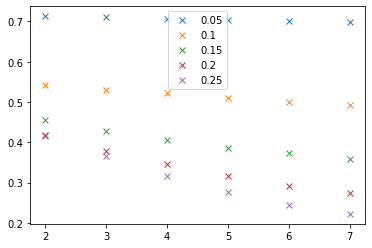

In [14]:
fig, ax = plt.subplots()
for key, group in pt.groupby(['death_rate']):
    # print(group)
    ax.plot(group.eliminated_days, group.alive_rate, 'x', label=str(key))
    
ax.legend()

In [15]:
pt = df.pivot_table(['alive_rate'], index=['death_rate', 'eliminated_days'],
                    aggfunc=('mean', 'std'))
pt = pt.reset_index()
pt

death_rate eliminated_days alive_rate          
                                    mean       std
0        0.05               2   0.712812  0.006649
1        0.05               3   0.711952  0.007302
2        0.05               4   0.706012  0.006815
3        0.05               5   0.703528  0.006500
4        0.05               6   0.701636  0.005961
5        0.05               7   0.699508  0.007480
6        0.10               2   0.543112  0.008508
7        0.10               3   0.529504  0.009465
8        0.10               4   0.522828  0.011215
9        0.10               5   0.509312  0.008136
10       0.10               6   0.500496  0.008750
11       0.10               7   0.491900  0.008098
12       0.15               2   0.455020  0.011922
13       0.15               3   0.427860  0.009288
14       0.15               4   0.406256  0.009499
15       0.15               5   0.386100  0.010319
16       0.15               6   0.372984  0.008678
17       0.15               7   0.358076  0.009724
18       0.20               2   0.417404  0.013793
19       0.20               3   0.378768  0.011040
20       0.20               4   0.345736  0.010569
21       0.20               5   0.317108  0.011411
22       0.20               6   0.291456  0.007800
23       0.20               7   0.274392  0.009955
24       0.25               2   0.416584  0.013181
25       0.25               3   0.365180  0.012979
26       0.25               4   0.316516  0.011756
27       0.25               5   0.277024  0.011228
28       0.25               6   0.245496  0.009125
29       0.25               7   0.222340  0.008615